
### Evaluation



In [1]:
#import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
#import pdb

In [2]:

def ridge(x, y, M, D, K, sigma_sq):

    X = x[:, 0:K-1,:] # batch_size, K-1, D
    I = sigma_sq * torch.eye(D).cuda()
    Cxx = torch.einsum('bij, bjk -> bik', X.permute([0,2,1]), X) + I[None,:,:] # X'*X
    Cxx_inv = torch.linalg.inv(Cxx) # batch_size, D, D

    Cxx_inv_X = torch.einsum('bij, bjk -> bik', Cxx_inv, X.permute([0,2,1])) # batch_size, D, K-1
    w_ridge =  torch.einsum('bij, bj -> bi', Cxx_inv_X, y[:,0:K-1,0]) # batch_size, D
    query = x[:, K-1,:]# batch_size, D

    yhat = torch.sum( w_ridge*query, dim=1).unsqueeze(1) # batch_size, 1

    return yhat




In [3]:
def validation(args, M, device):


    num_iterations = (50000//args.batch_size)

    avg_loss_ridge = 0

    # generate M task vectors
    w_pretrain = torch.randn(M, args.D).cuda()

    for batch_idx in range(num_iterations):

      # x ~ N(0, I)
      x = torch.randn(args.batch_size, args.K, args.D, device=device)

      # y = w'*x + epsilon
      # w ~ T_pretrain

      task_idx = torch.randint(low=0, high=M, size=(args.batch_size,), device=device)
      w = torch.index_select(w_pretrain, 0, task_idx) # batch_size, D

      # w'*x
      wx = torch.einsum('bij, bj -> bi', x, w).unsqueeze(2) #  batch_size, K, 1
      epsilon = torch.randn(args.batch_size, args.K, 1, device=device) * (args.sigma_sq**0.5)
      y = wx + epsilon

      yhat_ridge=ridge(x, y, M, args.D, args.K, args.sigma_sq)
      loss_ridge = torch.mean((yhat_ridge - y[:,args.K-1,:])**2)

      avg_loss_ridge += loss_ridge.item()


    avg_loss_ridge /= num_iterations

    return avg_loss_ridge


In [4]:
def test(args, M, device):


    num_iterations = (50000//args.batch_size)

    avg_loss_ridge = 0

    for batch_idx in range(num_iterations):

      # x ~ N(0, I)
      x = torch.randn(args.batch_size, args.K, args.D, device=device)

      # y = w'*x + epsilon

      # w ~ N(0, I_D), T_true
      w = torch.randn(args.batch_size, args.D, device=device) # batch_size, D

      # w'*x
      wx = torch.einsum('bij, bj -> bi', x, w).unsqueeze(2) #  batch_size, K, 1
      epsilon = torch.randn(args.batch_size, args.K, 1, device=device) * (args.sigma_sq**0.5)
      y = wx + epsilon

      yhat_ridge=ridge(x, y, M, args.D, args.K, args.sigma_sq)
      loss_ridge = torch.mean((yhat_ridge - y[:,args.K-1,:])**2)

      avg_loss_ridge += loss_ridge.item()


    avg_loss_ridge /= num_iterations

    return avg_loss_ridge




## MSE on $\mathcal{T_{pretrain}}$ and $\mathcal{T}_{true}$

$$ \mathcal{T_{pretrain}} \neq \mathcal{T}_{true}$$

But, as $M \rightarrow \infty$, $ \mathcal{T_{pretrain}} \rightarrow \mathcal{T}_{true}$.

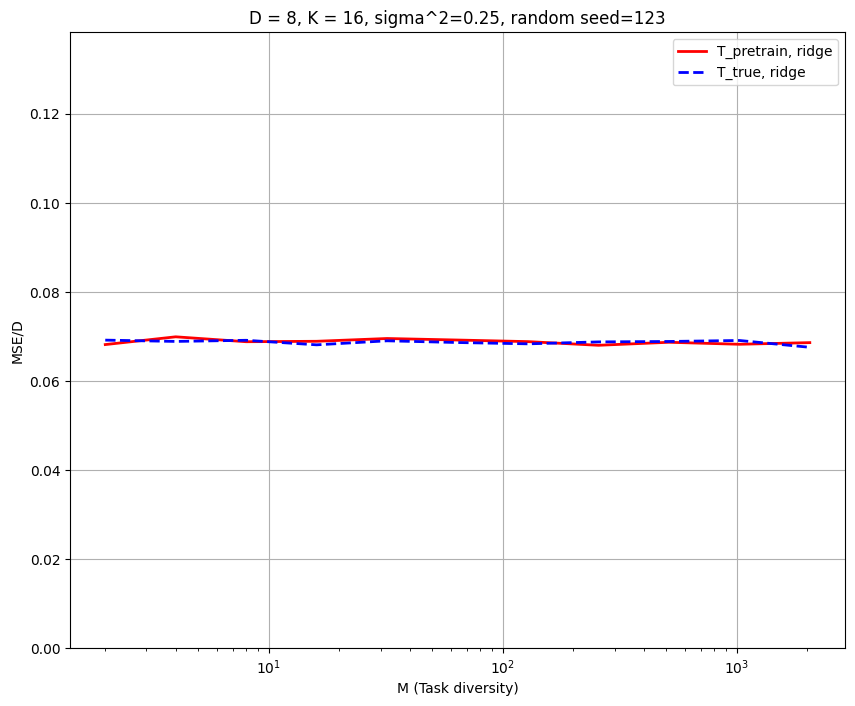

In [5]:
from dataclasses import dataclass

@dataclass
class args:
    batch_size: int
    epophs: int
    lr: float
    seed: int
    M: int
    D: int
    K: int
    sigmasq: float
    save_model: int


args.batch_size = 256
args.seed= 123 # random seed

args.sigma_sq = 0.25 # noise variance of epsilon. 0.25 assumed in the paper

#args.M=32 # task diversity
args.D=8 # dim of w
args.K=16


torch.manual_seed(args.seed)
device = torch.device("cuda")

valid_mse_ridge = []
test_mse_ridge = []


for Mexp in range(1,12):

    M=2**Mexp # task diversty

    # Evaluate on T_pretrain
    mse_ridge = validation(args, M, device)
    # MSE/D
    valid_mse_ridge.append(mse_ridge/args.D)

    # Evaluate on T_rue.
    mse_ridge = test(args, M, device)
    # MSE/D
    test_mse_ridge.append(mse_ridge/args.D)



import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

plt.semilogx(2**np.arange(1,12), valid_mse_ridge, label='T_pretrain, ridge', color='red', linestyle='-', linewidth=2)
plt.semilogx(2**np.arange(1,12), test_mse_ridge, label= 'T_true, ridge', color='blue', linestyle='--', linewidth=2)


plt.title( "D = "+str(args.D)+", K = "+str(args.K) + ", sigma^2="+str(args.sigma_sq) + ", random seed="+str(args.seed))
plt.xlabel('M (Task diversity)')
plt.ylabel('MSE/D')
plt.ylim(0, np.max(test_mse_ridge)*2)

plt.grid(True)
plt.legend()
plt.show()



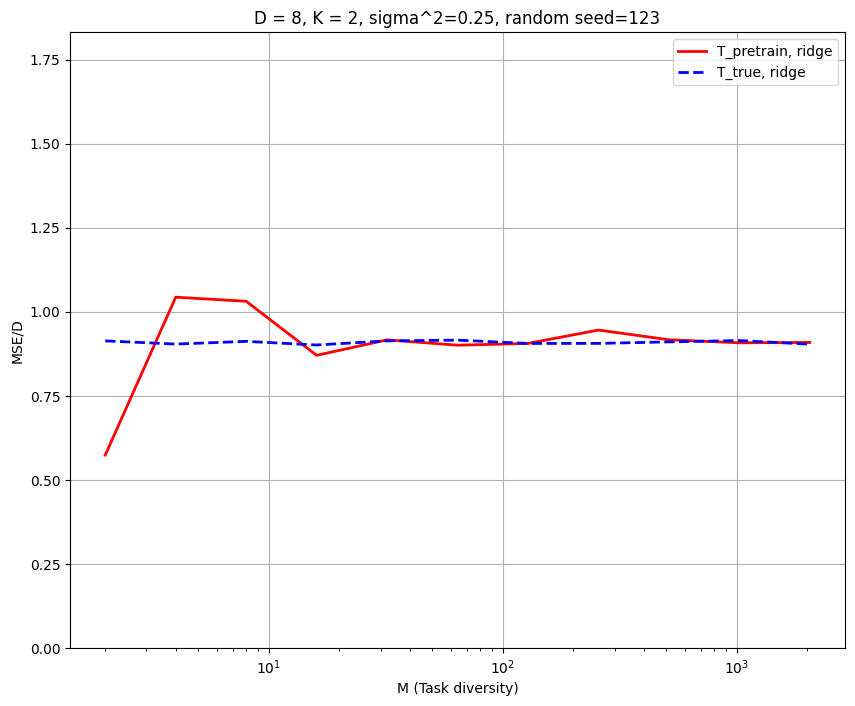

In [6]:
from dataclasses import dataclass

@dataclass
class args:
    batch_size: int
    epophs: int
    lr: float
    seed: int
    M: int
    D: int
    K: int
    sigmasq: float
    save_model: int


args.batch_size = 256
args.seed= 123 # random seed

args.sigma_sq = 0.25 # noise variance of epsilon. 0.25 assumed in the paper

args.D=8 # dim of w
args.K=2


torch.manual_seed(args.seed)
device = torch.device("cuda")

valid_mse_ridge = []
test_mse_ridge = []


for Mexp in range(1,12):

    M=2**Mexp # task diversty

    # Evaluate on T_pretrain
    mse_ridge = validation(args, M, device)
    # MSE/D
    valid_mse_ridge.append(mse_ridge/args.D)

    # Evaluate on T_rue
    mse_ridge = test(args, M, device)
    # MSE/D
    test_mse_ridge.append(mse_ridge/args.D)


import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

plt.semilogx(2**np.arange(1,12), valid_mse_ridge, label='T_pretrain, ridge', color='red', linestyle='-', linewidth=2)
plt.semilogx(2**np.arange(1,12), test_mse_ridge, label= 'T_true, ridge', color='blue', linestyle='--', linewidth=2)


plt.title( "D = "+str(args.D)+", K = "+str(args.K) + ", sigma^2="+str(args.sigma_sq) + ", random seed="+str(args.seed))
plt.xlabel('M (Task diversity)')
plt.ylabel('MSE/D')
plt.ylim(0, np.max(test_mse_ridge)*2)

plt.grid(True)
plt.legend()
plt.show()

